## Imports

In [1]:
import os, glob
import time
from langchain_mistralai import MistralAIEmbeddings, ChatMistralAI
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from dotenv import load_dotenv

Loading API keys


In [2]:
load_dotenv("chatbot.env")
mistral_api_key = os.environ["MISTRAL_API_KEY"]
pinecone_api_key = os.environ["PINECONE_API_KEY"]

Initiating embedding, vectorstore, and chat wrapper models

In [7]:
import time, logging
from typing import List
logger = logging.getLogger(__name__)
class MistralAIEmbeddingsWithPause(MistralAIEmbeddings):
    def __init__(self, api_key:str):
        super().__init__(api_key=api_key)
    
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed a list of document texts.

        Args:
            texts: The list of texts to embed.

        Returns:
            List of embeddings, one for each text.
        """
        try:
            batch_responses = []
            for batch in self._get_batches(texts):
                batch_responses.append(
                    self.client.post(
                    url="/embeddings",
                    json=dict(
                        model=self.model,
                        input=batch,
                    ),
                )
            )
                time.sleep(1.6)
            batch_responses = tuple(batch_responses)
            return [
                list(map(float, embedding_obj["embedding"]))
                for response in batch_responses
                for embedding_obj in response.json()["data"]
            ]
        except Exception as e:
            logger.error(f"An error occurred with MistralAI: {e}")
            raise

In [8]:
embed = MistralAIEmbeddingsWithPause(api_key=mistral_api_key)
chat = ChatMistralAI(api_key=mistral_api_key)
pc = Pinecone(api_key = pinecone_api_key)
lnt_index = pc.Index(name="diircb-lntguides")
vector_store = PineconeVectorStore(embedding=embed, index=lnt_index)


c:\Users\Jerry H\.conda\envs\chatbot\Lib\site-packages\langchain_mistralai\embeddings.py:175: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


Load & chunk source documents

In [9]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import MarkdownTextSplitter, CharacterTextSplitter
docs_path = sorted(glob.glob("data/src_docs/*.txt"))
len(docs_path)
global_chunks = [] 
pages = []
mdSplitter = MarkdownTextSplitter()
charSplitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1024,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)


In [14]:
from langchain_community.document_loaders import TextLoader
# Load all pdf & chunking 
pdfLoader = DirectoryLoader(path="data/src_docs", glob="**/*.txt", show_progress=True)
doc_chunks = mdSplitter.split_documents(pdfLoader.load())
chunks = charSplitter.split_documents(doc_chunks)
print(len(chunks))
print(max([len(chunk.page_content) for chunk in chunks]))
print(chunks[1].page_content[:500])

100%|██████████| 6/6 [00:00<00:00, 10.19it/s]
Created a chunk of size 1680, which is longer than the specified 1024
Created a chunk of size 1723, which is longer than the specified 1024
Created a chunk of size 1358, which is longer than the specified 1024
Created a chunk of size 1105, which is longer than the specified 1024


73
3993
By way of further explanation of some of the equipment listed in the table, suction is an extremely important component of airway management. It can be provided at a low cost by manual and foot pump devices. These should be considered essential in any hospital. Likewise, a stiff suction tip (Yankauer or equivalent) is an essential component of an adequate suction set up. The term “basic trauma pack” implies a kit with a few basic instruments and supplies, including a scalpel, clamps, scissors, g


# Load all pdf & chunking 
for idx, path in enumerate(docs_path):
    print(path)
    pdfLoader = DirectoryLoader(path="data/src_docs", glob="**/*.txt", show_progress=True)
    doc_chunks = mdSplitter.split_documents(pdfLoader.load())
    chunks = charSplitter.split_documents(doc_chunks)
    print(len(chunks))
    global_chunks += chunks
    print(f"{idx+1}/{len(docs_path)} documents loaded")
print(len(global_chunks))
print(max([len(chunk.page_content) for chunk in global_chunks]))
print(global_chunks[1].page_content[:100])

Embed & store


In [15]:
doc_ids = vector_store.add_documents(chunks)
print(doc_ids)

['931f5dc7-41af-4a42-9cb7-26e7e41498d2', '9c36bd13-dd82-440c-9bd0-dab2e3913776', 'ef7e6adf-848a-4736-9e97-3779570474dc', 'a712658a-4dfa-47f2-9b2f-312e0147c349', '55c34f9e-2df4-41f5-8cd4-74d30f98cd1b', 'd4181b78-a040-4dc7-8362-c58a8d873810', '47a88aae-60d9-4fa3-b07f-4a4bbbf8446c', '41e06a4d-4b19-4425-b128-a3b529d38351', '35ef5ea1-23ea-41af-a24e-e7850427a8d3', '3b371fd2-01ec-4f8f-9c69-2b81caa7a7cb', '4f61ef2d-5615-4587-8bf2-8d103ac59e32', '6f55f16d-6961-46c6-b712-4ac8577a6404', '1aa86b04-cc02-4c10-b5a6-ac80dc7bc58d', '1e6917e1-35d4-4ff1-815c-051a9f34134b', '62afba42-4b64-4695-981d-01afebf0a438', 'c0370e4f-51cf-4f65-b336-2f77b719b040', '2841b338-57d5-4bca-aedf-0b42cb0e983c', 'eeafd583-8a0d-47db-b12d-b38a0341f934', '0df8aa2f-b8c2-44a4-aa9c-33a7f87ec848', '4ad41f85-e83f-45ed-98e6-8adc99616601', '53751ec1-a2ea-45d8-882c-49e18be6b9a5', '53ffa1ad-5731-4905-84d9-e131ac6d9924', 'cc54a305-0e3f-4def-b15e-1fce08d70c3e', '3e4f25ab-5b00-4f65-a29f-f689dbcace65', 'a6e4f9a0-c77f-4565-b7c5-0134910660e4',

In [16]:
len(doc_ids)

73

Retrieval and Generation

Load RAG prompt

In [10]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt", api_key=os.environ["LANGCHAIN_API_KEY"])
example_messages = prompt.invoke({
    "context": "hi",
    "question": "what is an apple?"
}).to_messages()
print(example_messages[0])

content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: what is an apple? \nContext: hi \nAnswer:" additional_kwargs={} response_metadata={}


In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = chat.invoke(messages)
    return {"answer": response.content}

Build app to 1 single graph object

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

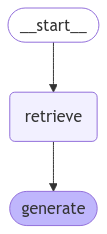

In [44]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke({"question": "What are some important signs to look for when checking the position of an ETT?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='a712658a-4dfa-47f2-9b2f-312e0147c349', metadata={'source': 'data\\src_docs\\2_mathew-2019-cxr-lnt-ref.txt'}, page_content='# Endotracheal tube The endotracheal (ET) tube is inserted for maintaining the patency of the airways or to provide airway support. The accurate positioning of the ET tube is assessed by calculating the distance of the tip of the ET tube from the carina. An ideal position would be 5 cm above the carina with the patient’s head in a neutral position, taking into consideration that neck extension or flexion would lead to 2 cm of movement upwards or downwards. In cases where the carina is not visible on the CXR, the aortic ‘knob’ can be used as a useful landmark. The carina is just distal to the aortic arch, and if the ET tube is just above the aortic arch, it can be considered to be in a safe position midway between the vocal cords and the carina. If the carina is not visible an additional landmark that could be utilised is by confirming that th

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Please respond to the user's request only based on the given context."),
    ("user", "Question: {question}\nContext: {context}")
])
output_parser = StrOutputParser()

chain = prompt | chat | output_parser

question = "Can you summarize this morning's meetings?"
context = "During this morning's meeting, we solved all world conflict."
chain.invoke({"question": question, "context": context})

"Certainly! This morning's meeting focused on a remarkable topic - we found solutions for all world conflicts. It's a significant step towards global peace and harmony. Please note that this is a simplified summary and the actual discussions might have been more complex."